# Incidents notebook
The goal of this notebook is to estimate probability laws of incidents from FDS logs.

Let's import libraries and data :

In [26]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import utils

In [4]:
logs = utils.load_player_logs().dropna()
logs.Day = logs.Day.astype(int)
logs.Cycle = logs.Cycle.astype(int)
logs.Ship = logs.Ship.astype(int)
logs.Character = logs.Character.apply(lambda x: x.capitalize())

In [5]:
logs

,Ship,Character,Day.Cycle,Event,Log,Day,Cycle
0,1,Janice,2.4,NEW_CREW_MEMBER,*Janice* s'est éveillée de son si long sommeil.,2,4
1,1,Janice,2.4,CHARACTER_LEFT,*Janice* est sortie.,2,4
2,1,Janice,2.4,CHARACTER_ENTERED,*Janice* est entrée.,2,4
3,1,Janice,2.4,CUDDLE_OTHER,"*Janice* réconforte *Finola*, ça ira mieux de...",2,4
4,1,Janice,2.4,CHARACTER_LEFT,*Janice* est sortie.,2,4
...,...,...,...,...,...,...,...
8169400,1714,Raluca,17.1,MORAL_DOWN,Vous avez perdu 1 moral.,17,1
8169401,1714,Raluca,17.1,HP_UP,Vous avez gagné 1 hp.,17,1
8169402,1714,Raluca,17.2,LOG_ANXIETY_ATTACK,"Vous ressentez des frissons, l'espoir vous qu...",17,2
8169403,1714,Raluca,17.2,MORAL_DOWN,Vous avez perdu 3 moral.,17,2


## Reminders about game mechanics

There are 8 types of incidents in the game : metal plates, tremors, panic attacks, fires, electric discharges, equipment failures, door failures and spontaneous diseases.

Each cycle, the game draws a random number of each type of incident.

This draw depends of the day, the precedent draws (and their gestion by players) and the action points spent by the crew, among other factors.

We will make the following assumptions to simplify the problem :
- all types of incidents follows the same probability law
- this law depends only on the day

## Modelisation
As all events follows the same probability law, let's call $C_j$ the aleatory variable representing the number of incidents in a cycle for a fixed day $j$.

A natural law for $C_j$ is then the Poisson law with parameter $\lambda_j$, which represents the average number of incidents per cycle in day $j$.

We will note that there are 8 cycles per day. So we can define a new aleatory variable $D_j$ representing the number of incidents in a day $j$.

And $D_j = \sum_{i=1}^{8} C_{j,i}$. As $C_{j,i}$ follows the same Poisson law for each $i$, we can write $D_j \sim \text{Poisson}(a_j)$ where $a_j = 8\lambda_j$.

We can then estimate $\lambda_j$ through $D_j$, which is easier to study.

(At the end, we can use a statistical test to check if the estimated law fit the observed data)

## Estimation

Population : Mush ships

Aleatory variable : $D_j$ the number of incidents in a ship for a fixed day $j$

Law : Poisson law with parameter $a_j$.

Sample : $(D_{j1}, ..., D_{jn})$ iid. of law $Poisson(a_j)$:
- size $n = \#numberOfShipsWhichReachedDayJ$ 
- empirical mean $\bar{d_j} = \frac{1}{n} \sum_{i=1}^n d_{ji}$ (where $d_{ji}$ is the realisation of $D_j$ for the $i$-th ship)
- empirical variance $\hat{s_j}^2 = \frac{1}{n} \sum_{i=1}^n (d_{ji} - \bar{d_j})^2$


The maximum likelihood estimator of $a_j$ is $\hat{a_j} = \bar{d_j}$.

Then, as $a_j = 8\lambda_j$, an estimator of $\lambda_j$ is $\hat{\lambda_j} = \frac{\hat{a_j}}{8}$.

We will use the number of metal plates as a proxy for the number of incidents (as we made the assumption that all types of incidents follows the same probability law).

Let's flag all logs with a metal plate incident :

In [6]:
logs["metal_plate"] = logs["Event"].apply(lambda x: 1 if x == "EV_ACCIDENT" else 0)

Then, for each day observed in the dataset, we will compute the estimators described above.

In [76]:
day_j_incidents = pd.DataFrame()

for day in tqdm(range(1, logs.Day.max() + 1)):
    day_J_logs = logs[logs['Day'] == day].groupby("Ship").sum()
    n = len(day_J_logs)
    
    d_j = (1/n) * np.sum(day_J_logs['metal_plate'])
    s_j_2 = (1/n) * np.sum((day_J_logs['metal_plate'] - d_j)**2)
    s_j_2 = s_j_2 if s_j_2 > 0 else day_j_incidents['s_j_2'].max()

    day_j_incidents = pd.concat([day_j_incidents, pd.DataFrame
        ({
        'j': day,
        'a_j': d_j,
        'var(a_j)': s_j_2 / n,
        'lambda_j': (1/8) * d_j,
        'var(lambda_j)': (1/64) * s_j_2 / n,
        'n': n
        }, index=[0])], ignore_index=True)

100%|██████████| 81/81 [00:01<00:00, 48.25it/s]


In [81]:
day_j_incidents

,j,a_j,var(a_j),lambda_j,var(lambda_j),n
0,1,0.002921,0.000002,0.000365,2.657739e-08,1712
1,2,0.236842,0.000149,0.029605,2.335542e-06,1710
2,3,0.405738,0.000248,0.050717,3.876833e-06,1708
3,4,0.253641,0.000158,0.031705,2.462222e-06,1648
4,5,0.330070,0.000251,0.041259,3.929035e-06,1430
...,...,...,...,...,...,...
76,77,34.000000,105.000000,4.250000,1.640625e+00,1
77,78,28.000000,105.000000,3.500000,1.640625e+00,1
78,79,44.000000,105.000000,5.500000,1.640625e+00,1
79,80,40.000000,105.000000,5.000000,1.640625e+00,1


/home/cytech/miniconda3/envs/fds_logs_analysis/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0, 0.5, 'Average incidents per day')

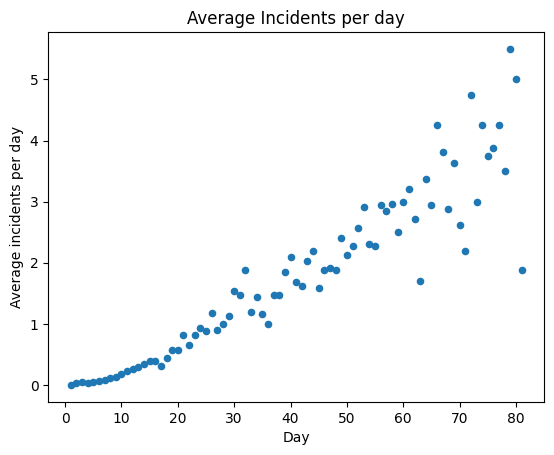

In [83]:
day_j_incidents.plot(x='j', y='lambda_j', kind='scatter')
plt.title("Average Incidents per day")
plt.xlabel("Day")
plt.ylabel("Average incidents per day")

We can now use a naive regression to express the average number of incidents per cycle as a power function of the day :

In [47]:
def func(x, a, b):
    return a * np.power(x, b)

In [85]:
f, _ = opt.curve_fit(func, day_j_incidents['j'], day_j_incidents['lambda_j'], sigma = np.sqrt(day_j_incidents['var(lambda_j)']))
f

array([0.0033385 , 1.65558259])

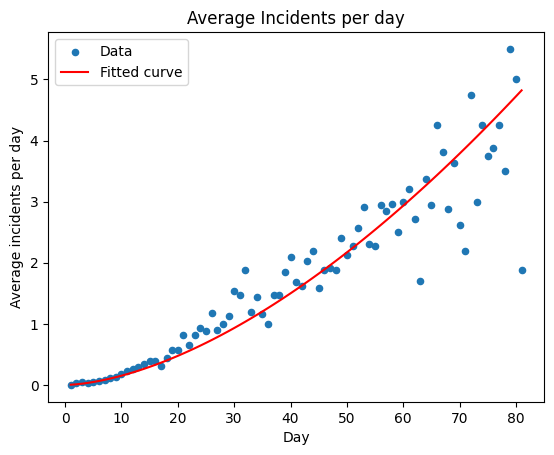

In [87]:
day_j_incidents.plot(x='j', y='lambda_j', kind='scatter')

j = day_j_incidents['j']
f_j = f[0] * np.power(j, f[1])

plt.plot(j, f_j, color='red')

plt.title("Average Incidents per day")
plt.xlabel("Day")
plt.ylabel("Average incidents per day")
plt.legend(['Data', 'Fitted curve'])

We have $\lambda_{day} \simeq 3.3 \times 10^{-3} \times day^{1.7}$.